### Import Packages

In [1]:
import pandas as pd
import os
from os.path import isfile, join
import time
import re
import numpy as np
from tqdm.notebook import tqdm
import pickle
import pandas as pd
import itertools
from collections import Counter
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from gensim.models import word2vec
import os
import string
import spacy
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from scipy.sparse import csr_matrix
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# sentiment_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, f1_score, accuracy_score, roc_curve
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

### Load Data

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
filePath = ["./aclImdb/train/", "./aclImdb/test/"]
tag = ["pos/", "neg/"]
for i in filePath:
    for j in tag:
        start = time.time()
        path = i+j
        onlyfiles = [f for f in os.listdir(path) if isfile(join(path, f))]
        end = time.time()
        print(f"Detect {len(onlyfiles)} files at the current path:'{path}', time: {round(end-start, 4)}s.")
# onlyfiles

Detect 12500 files at the current path:'./aclImdb/train/pos/', time: 11.9585s.
Detect 12500 files at the current path:'./aclImdb/train/neg/', time: 10.1574s.
Detect 12500 files at the current path:'./aclImdb/test/pos/', time: 10.813s.
Detect 12500 files at the current path:'./aclImdb/test/neg/', time: 11.4046s.


In [ ]:
testPosPath = './aclImdb/test/pos/'
testNegPath = './aclImdb/test/neg/'
testfiles = [f for f in os.listdir(testPosPath) if isfile(join(testPosPath, f))]
testfiles += [f for f in os.listdir(testNegPath) if isfile(join(testNegPath, f))]

In [ ]:
Xtest = []
ytest = [1] * 12500 + [0] * 12500
# filedir = "./aclImdb/test/neg/"
start = time.time()
for i in range(len(testfiles)):
    file = testfiles[i]
    if i < 12500:
        filedir = "./aclImdb/test/pos/"
    else:
        filedir = "./aclImdb/test/neg/"
    path = filedir + file
    rating = re.findall("[0-9]+_([0-9]+).txt", file)[0]
    with open(path, "r") as f:
        contents = f.read()
        Xtest.append([contents, rating])
end = time.time()
print("Time :{}s.".format(round(end- start, 4)))

Time :58.0446s.


In [ ]:
test = pd.DataFrame(Xtest, columns = ["text", 'rating'])
test['label'] = ytest
print(test.shape)
test.head()

(25000, 3)


,text,rating,label
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1


In [ ]:
trainPosPath = './aclImdb/train/pos/'
trainNegPath = './aclImdb/train/neg/'
trainfiles = [f for f in os.listdir(trainPosPath) if isfile(join(trainPosPath, f))]
trainfiles += [f for f in os.listdir(trainNegPath) if isfile(join(trainNegPath, f))]

In [ ]:
Xtrain = []
ytrain = [1] * 12500 + [0] * 12500
# filedir = "./aclImdb/test/neg/"
start = time.time()
for i in range(len(trainfiles)):
    file = trainfiles[i]
    if i < 12500:
        filedir = "./aclImdb/train/pos/"
    else:
        filedir = "./aclImdb/train/neg/"
    path = filedir + file
    rating = re.findall("[0-9]+_([0-9]+).txt", file)[0]
    with open(path, "r") as f:
        contents = f.read()
        Xtrain.append([contents, rating])
end = time.time()
print("Time :{}s.".format(round(end- start, 4)))

Time :60.4491s.


In [ ]:
train = pd.DataFrame(Xtrain, columns = ["text", 'rating'])
train['label'] = ytrain
print(train.shape)
train.head()

(25000, 3)


,text,rating,label
0,Bromwell High is a cartoon comedy. It ran at t...,9,1
1,Homelessness (or Houselessness as George Carli...,8,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,1
3,This is easily the most underrated film inn th...,7,1
4,This is not the typical Mel Brooks film. It wa...,8,1


### Preprocess

In [ ]:
def preprocess_df(df, col = "text", target_col = 'clean_text'):
    # get English stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    # prepare translation table to translate punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row[col]
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word for word in words_list if word not in stop_words and len(word) != 1] # also skip space from above translation
        preprocessed_sentences.append(" ".join(filtered_words))
    df[target_col] = preprocessed_sentences
    return df

In [ ]:
train = preprocess_df(train)
test = preprocess_df(test)

In [ ]:
import en_core_web_sm
import re
nlp_processor = en_core_web_sm.load()
nltk.download('stopwords') # <--- this is new
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
def pre_processing_by_spacy(doc, lemma = True, need_sent = False):
    doc_class = nlp_processor(doc)
    tokens = []
    # step 1: get sentences
    for sent in doc_class.sents:
        # step 2: get tokens
        # step 3 (optional): lemma
        if lemma:
            words = [token.lemma_ for token in sent]
        else:
            words = [token.text for token in sent]
        if need_sent:
            tokens.append(words)
        else:
            tokens += words
            
    raw_corpus = re.sub(r'[^\w\s]', ' ', ' '.join(tokens)).split()
    corpus = [w.lower() for w in raw_corpus if w.lower() not in stop]
    
    return corpus

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# tokenization -> preprocess by spacy 
tagged_data = [pre_processing_by_spacy(_d) for i, _d in tqdm(enumerate(train["clean_text"]))]

0it [00:00, ?it/s]

In [ ]:
# tokenization -> preprocess by spacy 
tagged_test_data = [pre_processing_by_spacy(_d) for i, _d in tqdm(enumerate(test["clean_text"]))]

0it [00:00, ?it/s]

In [ ]:
# save tagged train data
with open("data/tagged_train_data.txt", "w") as f:
    for s in tqdm(tagged_data):
        f.write(str(s) +"\n")
with open("data/tagged_test_data.txt", "w") as f:
    for s in tqdm(tagged_test_data):
        f.write(str(s) +"\n")

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

#### Load preprocessed data
- Format: tokenized list


In [4]:
trans_dict = {"[": "", ',':"", "]":"", "'":""}
translator = str.maketrans(trans_dict)
ytrain = [1] * 12500 + [0] * 12500
ytest = ytrain
tagged_data =[]
tagged_test_data = []
with open("/content/drive/MyDrive/Colab Notebooks/data/IMDB/tagged_train_data.txt", "r") as f:
    for line in tqdm(f):
        tagged_data.append(line.translate(translator).split())
with open("/content/drive/MyDrive/Colab Notebooks/data/IMDB/tagged_test_data.txt", "r") as f:
    for line in tqdm(f):
        tagged_test_data.append(line.translate(translator).split())

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
tagged_data[0][:5]

['bromwell', 'high', 'cartoon', 'comedy', 'run']

### Rule-based

In [ ]:
ypred1 = []
for l in tqdm(tagged_test_data):
    dct = sentiment_analyzer.polarity_scores(' '.join(l))
    if dct['pos'] >= dct['neg']:
        ypred1.append(1)
    else:
        ypred1.append(0)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print(accuracy_score(ytest, ypred1))

0.67156


In [ ]:
ypred1 = []
for l in tqdm(train.clean_text):
    dct = sentiment_analyzer.polarity_scores(l)
    if dct['pos'] >= dct['neg']:
        ypred1.append(1)
    else:
        ypred1.append(0)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print(accuracy_score(ytest, ypred1))

0.67172


### Binary Encoding For Adj + Adv

In [ ]:
tagged_sents = []
tags = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBs']
for i in tqdm(range(len(tagged_data))):
    tagged_sents += [w for w, tag in pos_tag(tagged_data[i]) if tag in tags]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
vocab = list(set(tagged_sents))
print("Size of adj/adv vocab = {}".format(len(vocab)))

Size of adj/adv vocab = 31974


In [ ]:
# A function used to build a vocabulary based on descending word frequencies 
def build_vocab(sentences):
    # Build vocabulary
    word_counts = Counter(sentences)
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_sents)

In [ ]:
vocab_freqs = list(word_counts.values())
vocab_freqs.sort(reverse = True)
print("Total vocabs = {}".format(len(vocab_freqs)))

Total vocabs = 31974


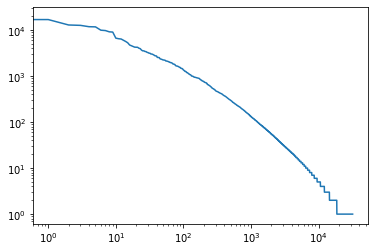

In [ ]:
import matplotlib.pyplot as plt
plt.loglog(vocab_freqs)
plt.show()

In [ ]:
for i in range(10):
  size = 0
  for j in range(1,i+1):
    size += vocab_freqs.count(j)
  print('Vocab size = {}, with freq >= {}'.format(31974 - size, i+1))

Vocab size = 31974, with freq >= 1
Vocab size = 18618, with freq >= 2
Vocab size = 14479, with freq >= 3
Vocab size = 12180, with freq >= 4
Vocab size = 10641, with freq >= 5
Vocab size = 9509, with freq >= 6
Vocab size = 8620, with freq >= 7
Vocab size = 7927, with freq >= 8
Vocab size = 7355, with freq >= 9
Vocab size = 6880, with freq >= 10


In [ ]:
AllVocab = sorted(word_counts.items(), key = lambda k_v: k_v[1], reverse = True)
selectVocabs = [word for word, freq in AllVocab if freq >= 5]
print("Total Selected Vocabs = ", len(selectVocabs))

Total Selected Vocabs =  10641


In [ ]:
Xtrain = []
for tokens in tqdm(tagged_data):
    s = list(set(tokens))
    Xtrain.append([s.count(w) for w in selectVocabs])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
Xtest = []
for tokens in tqdm(tagged_test_data):
    s = list(set(tokens))
    Xtest.append([s.count(w) for w in selectVocabs])

  0%|          | 0/25000 [00:00<?, ?it/s]

#### Save Tokenized Data

In [87]:
# save tagged train data
with open("/content/drive/MyDrive/Colab Notebooks/data/IMDB/Xtrain_sent_bin.txt", "w") as f:
    for s in tqdm(Xtrain):
        f.write(str(s) +"\n")
with open("/content/drive/MyDrive/Colab Notebooks/data/IMDB/Xtest_sent_bin.txt", "w") as f:
    for s in tqdm(Xtest):
        f.write(str(s) +"\n")

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

#### Read Tokenized Data

In [5]:
trans_dict = {"[": "", ',':"", "]":"", "'":""}
translator = str.maketrans(trans_dict)
ytrain = [1] * 12500 + [0] * 12500
ytest = ytrain
Xtrain =[]
Xtest = []
with open("/content/drive/MyDrive/Colab Notebooks/data/IMDB/Xtrain_sent_bin.txt", "r") as f:
    for line in tqdm(f):
        Xtrain.append(list(map(int, line.translate(translator).split())))

0it [00:00, ?it/s]

In [6]:
ytest = ytrain
Xtest = []
with open("/content/drive/MyDrive/Colab Notebooks/data/IMDB/Xtest_sent_bin.txt", "r") as f:
    for line in tqdm(f):
        Xtest.append(list(map(int, line.translate(translator).split())))

0it [00:00, ?it/s]

In [7]:
# evaluate function
def evaluate(ytest, ypred, name):
    ypred_label = np.argmax(ypred, axis = 1)
    ypred_proba = ypred[:,1]
    accu = accuracy_score(ytest, ypred_label)
    f1 = f1_score(ytest, ypred_label)
    AUC = roc_auc_score(ytest, ypred_proba)
    fpr, tpr, _ = roc_curve(ytest, ypred_proba)
    
    lw = 2
    plt.figure(figsize = (6,6))
    plt.plot(fpr, tpr, lw = lw, label="ROC curve of model {}, AUC = ({:0.2f})".format(name, AUC))
    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    df = pd.DataFrame()
    df = df.assign(
        model = [name],
        accuracy = [accu],
        f1_score = [f1],
        AUC = [AUC]
    )
    print(df)
    return df

In [8]:
# shuffle data
train_ids = list(range(25000))
test_ids = list(range(25000))
import random
random.seed(233)
random.shuffle(train_ids)
random.shuffle(test_ids)

Xtrain_s = []
ytrain_s = []
Xtest_s = []
ytest_s = []
for i in train_ids:
  Xtrain_s.append(Xtrain[i])
  ytrain_s.append(ytrain[i])
for i in test_ids:
  Xtest_s.append(Xtest[i])
  ytest_s.append(ytest[i])
  
Xtrain_ = csr_matrix(Xtrain_s)
Xtest_ = csr_matrix(Xtest_s)

#### Logistic Regresion

In [27]:
%%time
clf = LogisticRegression(C = 20, max_iter = 100000000, random_state = 233)
clf.fit(Xtrain_, ytrain_s)

CPU times: user 9.29 s, sys: 10.9 s, total: 20.2 s
Wall time: 10.4 s


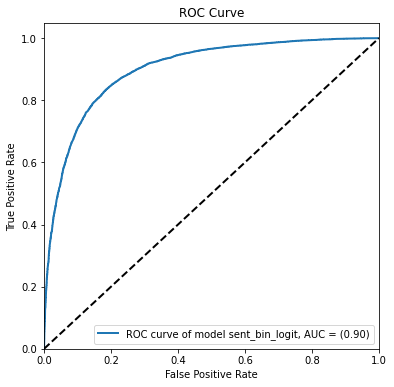

            model  accuracy  f1_score       AUC
0  sent_bin_logit   0.82236  0.820355  0.899927


In [28]:
ypred2 = clf.predict_proba(Xtest_)
eval1 = evaluate(ytest_s, ypred2, 'sent_bin_logit')

In [29]:
res1 = pd.DataFrame()
res1['ytest'] = ytest_s
res1['pred_0'] = ypred2[:,0]
res1['pred_1'] = ypred2[:,1]
res1.head()
res1.to_csv("/content/drive/MyDrive/Colab Notebooks/data/IMDB/res_POS_logit.csv", index = False)

#### Simple NN

In [30]:
# experience rules for hidden layer design
input_shape = len(Xtrain[0])
n = input_shape # dim of features
m = 2 # dim of output
h1 = int(np.log2(n))
h2 = int(np.sqrt(m + n)) + 3
h3 = 2 * n + 1
print(h1, h2, h3)

13 106 21283


##### size = (h1,), solver = 'Adam'

In [31]:
clf = MLPClassifier(
    hidden_layer_sizes = (h1,),
    alpha = 0.02,
    # solver = 'sgd',
    # early_stopping = True,
    # validation_fraction = 0.1,
)
clf.fit(Xtrain_, ytrain_s)

MLPClassifier(alpha=0.02, hidden_layer_sizes=(13,))

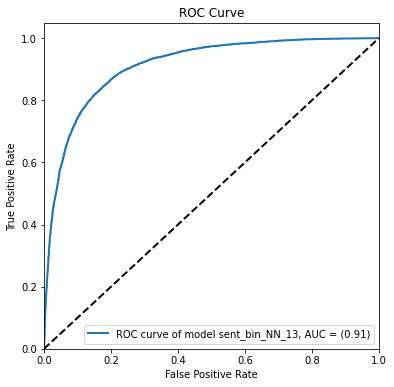

            model  accuracy  f1_score       AUC
0  sent_bin_NN_13   0.83404  0.834179  0.910793


In [32]:
ypred3 = clf.predict_proba(Xtest_)
eval2 = evaluate(ytest_s, ypred3, 'sent_bin_NN_13')

##### size = (h1,), solver = 'SGD'

In [33]:
clf = MLPClassifier(
    hidden_layer_sizes = (h1),
    alpha = 0.02,
    solver = 'sgd',
    # early_stopping = True,
    # validation_fraction = 0.1,
)
clf.fit(Xtrain_, ytrain_s)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(alpha=0.02, hidden_layer_sizes=13, solver='sgd')

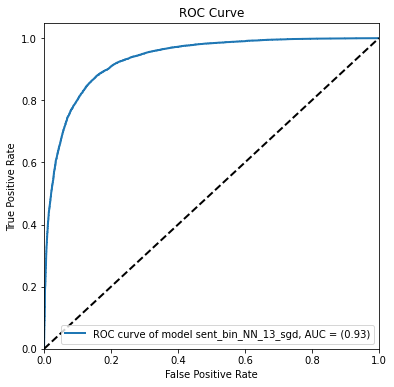

                model  accuracy  f1_score       AUC
0  sent_bin_NN_13_sgd   0.86036  0.860555  0.933688


In [34]:
ypred4 = clf.predict_proba(Xtest_)
eval3 = evaluate(ytest_s, ypred4, 'sent_bin_NN_13_sgd')

##### size = (h1,), solver = 'SGD', early_stopping

In [35]:
clf = MLPClassifier(
    random_state = 233,
    hidden_layer_sizes = (h1),
    alpha = 0.02,
    solver = 'sgd',
    max_iter = 1024,
    early_stopping = True,
    validation_fraction = 0.1,
)
clf.fit(Xtrain_, ytrain_s)

MLPClassifier(alpha=0.02, early_stopping=True, hidden_layer_sizes=13,
              max_iter=1024, random_state=233, solver='sgd')

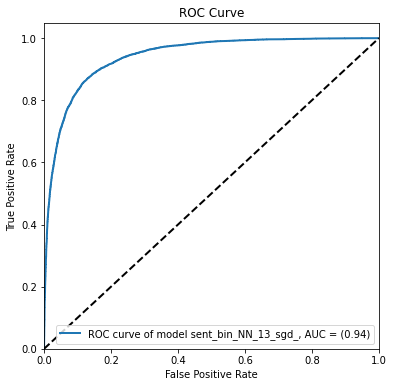

                 model  accuracy  f1_score       AUC
0  sent_bin_NN_13_sgd_   0.86984  0.870451  0.941107


In [36]:
ypred5 = clf.predict_proba(Xtest_)
eval4 = evaluate(ytest_s, ypred5, 'sent_bin_NN_13_sgd_')

##### size = (h2, h1,), solver = 'sgd'

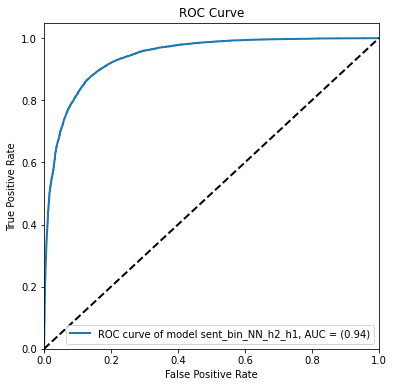

               model  accuracy  f1_score      AUC
0  sent_bin_NN_h2_h1   0.86836  0.868281  0.94066


In [38]:
clf = MLPClassifier(
    random_state = 233,
    hidden_layer_sizes = (h2,h1),
    alpha = 0.02,
    solver = 'sgd',
    max_iter = 1024,
    early_stopping = True,
    validation_fraction = 0.1,
)
clf.fit(Xtrain_, ytrain_s)
ypred6 = clf.predict_proba(Xtest_)
eval5 = evaluate(ytest_s, ypred6, 'sent_bin_NN_h2_h1')

In [40]:
evalAll = pd.concat([eval1, eval2, eval3, eval4, eval5])
evalAll

,model,accuracy,f1_score,AUC
0,sent_bin_logit,0.82236,0.820355,0.899927
0,sent_bin_NN_13,0.83404,0.834179,0.910793
0,sent_bin_NN_13_sgd,0.86036,0.860555,0.933688
0,sent_bin_NN_13_sgd_,0.86984,0.870451,0.941107
0,sent_bin_NN_h2_h1,0.86836,0.868281,0.940660


In [41]:
res2 = pd.DataFrame()
res2['ytest'] = ytest_s
res2['pred_0'] = ypred5[:,0]
res2['pred_1'] = ypred5[:,1]
res2.head()
res2.to_csv("/content/drive/MyDrive/Colab Notebooks/data/IMDB/res_POS_NN.csv", index = False)

#### Feature Selection

In [42]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [43]:
%%time
xgb = XGBClassifier(max_depth = 8,
                    n_estimators = 1000,
                    seed = 233,
                    reg_lambda = 0.01,
                    n_jobs = -1)
xgb.fit(Xtrain_, ytrain_s)

CPU times: user 4min 6s, sys: 244 ms, total: 4min 7s
Wall time: 2min 23s


In [45]:
importance = xgb.feature_importances_

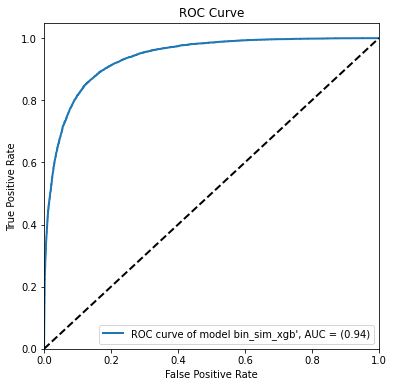

          model  accuracy  f1_score       AUC
0  bin_sim_xgb'   0.86328  0.863901  0.937851


In [46]:
eval6 = evaluate(ytest_s, xgb.predict_proba(Xtest_), "bin_sim_xgb'")

In [47]:
imp_ids = [i for i, imp in enumerate(importance) if imp > 1e-5]
len(imp_ids), max(imp_ids)

(2668, 10635)

In [48]:
new_Xtrain_s = []
new_Xtest_s = []
for i in tqdm(range(25000)):
  new_Xtrain_s.append(list(map(Xtrain_s[i].__getitem__, imp_ids)))
for i in tqdm(range(25000)):
  new_Xtest_s.append(list(map(Xtest_s[i].__getitem__, imp_ids)))

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [100]:
# save tagged train data
with open("/content/drive/MyDrive/Colab Notebooks/data/IMDB/Xtrain_sent_bin_select.txt", "w") as f:
    for s in tqdm(new_Xtrain_s):
        f.write(str(s) +"\n")
with open("/content/drive/MyDrive/Colab Notebooks/data/IMDB/Xtest_sent_bin_select.txt", "w") as f:
    for s in tqdm(new_Xtest_s):
        f.write(str(s) +"\n")

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

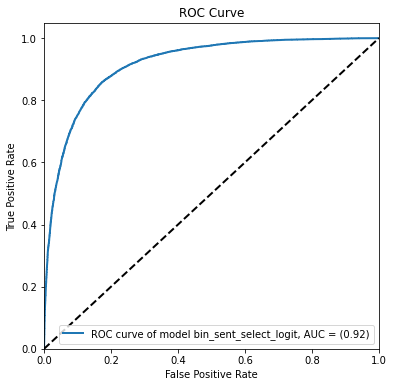

                   model  accuracy  f1_score       AUC
0  bin_sent_select_logit   0.84044  0.839664  0.917172


In [50]:
# test with logit
clf = LogisticRegression(C = 20, max_iter = 100000000, random_state = 233)
clf.fit(csr_matrix(new_Xtrain_s), ytrain_s)
ypred_new = clf.predict_proba(csr_matrix(new_Xtest_s))
eval7 = evaluate(ytest_s, ypred_new, 'bin_sent_select_logit')

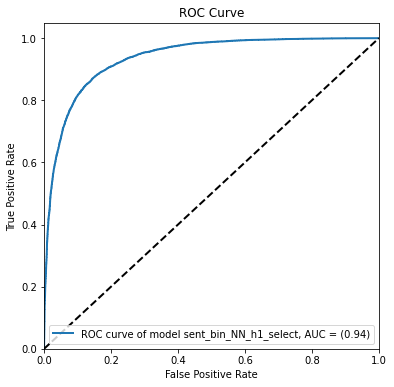

                   model  accuracy  f1_score       AUC
0  sent_bin_NN_h1_select   0.86272  0.863885  0.935962


In [51]:
# test with NN
clf = MLPClassifier(
    random_state = 233,
    hidden_layer_sizes = (h1),
    alpha = 0.02,
    solver = 'sgd',
    max_iter = 1024,
    early_stopping = True,
    validation_fraction = 0.1,
)
clf.fit(csr_matrix(new_Xtrain_s), ytrain_s)
ypred6_new = clf.predict_proba(csr_matrix(new_Xtest_s))
eval8 = evaluate(ytest_s, ypred6_new, 'sent_bin_NN_h1_select')

In [53]:
res3 = pd.DataFrame()
res3['ytest'] = ytest_s
res3['pred_0'] = ypred_new[:,0]
res3['pred_1'] = ypred_new[:,1]
res3.head()
res3.to_csv("/content/drive/MyDrive/Colab Notebooks/data/IMDB/res_POS_logit_select.csv", index = False)

In [54]:
res4 = pd.DataFrame()
res4['ytest'] = ytest_s
res4['pred_0'] = ypred6_new[:,0]
res4['pred_1'] = ypred6_new[:,1]
res4.head()
res4.to_csv("/content/drive/MyDrive/Colab Notebooks/data/IMDB/res_POS_NB_select.csv", index = False)

In [52]:
evalAll = pd.concat([eval1, eval2, eval3, eval4, eval5, eval6, eval7, eval8])
evalAll

,model,accuracy,f1_score,AUC
0,sent_bin_logit,0.82236,0.820355,0.899927
0,sent_bin_NN_13,0.83404,0.834179,0.910793
0,sent_bin_NN_13_sgd,0.86036,0.860555,0.933688
0,sent_bin_NN_13_sgd_,0.86984,0.870451,0.941107
0,sent_bin_NN_h2_h1,0.86836,0.868281,0.940660
0,bin_sim_xgb',0.86328,0.863901,0.937851
0,bin_sent_select_logit,0.84044,0.839664,0.917172
0,sent_bin_NN_h1_select,0.86272,0.863885,0.935962


In [55]:
evalAll.to_csv("/content/drive/MyDrive/Colab Notebooks/data/IMDB/evaluation.csv", index = False)